In [1]:
import geopandas as gp
import pandas as pd
from collections import Counter
import contextily as cx
import fiona


pd.set_option('display.max_columns', None)

# Georgia 2022 General Election Precinct Boundaries and Election Results

## Load Source Files

In [2]:
# Load precinct-level election results
ga = pd.read_csv("./raw-from-source/ga_2022_gen_prec_csv/ga_2022_gen_prec.csv")

# Load precinct shapefiles
ga_prec_shape = gp.read_file("./raw-from-source/ga-precincts2022-shape/GA-PRECINCTS2022-SHAPE.shp")

In [3]:
ga_prec_shape.shape

(2721, 13)

## Clean Source Files

In [4]:
# Cast the election results unique ID to upper case
ga["UNIQUE_ID"] = ga["UNIQUE_ID"].str.upper()

# Clean up null values in the precinct file
ga_prec_shape.loc[ga_prec_shape["PRECINCT_N"].isna(), "PRECINCT_N"] = ga_prec_shape["DISTRICT"]
ga_prec_shape.loc[ga_prec_shape["FIPS2"].isna(), "FIPS2"] = ga_prec_shape["DISTRICT"].str[0:3]

# Define possible unique ID from precinct shapefile
ga_prec_shape["UNIQUE_ID"] = ga_prec_shape["FIPS2"] + "-" + ga_prec_shape["PRECINCT_N"].str.upper()

print(ga_prec_shape["UNIQUE_ID"].value_counts())

051-7-11C SAVANNAH FIRE STATION 14            2
121-SC07A                                     1
051-7-06C 1ST BAPTIST CHURCH OF POOLER        1
051-1-13C THE SANCTUARY                       1
051-1-14C ST. LUKE UNITED METHODIST CHURCH    1
                                             ..
073-COL CTY BOARD OF EDU                      1
073-BLANCHARD PARK                            1
073-TRINITY BAPT CHURCH                       1
073-MARVIN METHODIST                          1
089-WINTERS CHAPEL                            1
Name: UNIQUE_ID, Length: 2720, dtype: int64


## Deal with Lone Duplicate Unique ID

It appears as though this chunk of "051-7-11C SAVANNAH FIRE STATION 14" belongs with "051-8-18C SAVANNAH FIRST 7TH DAY ADV CHURCH"

In [5]:
ga_prec_shape[(ga_prec_shape["UNIQUE_ID"].isin(["051-7-11C SAVANNAH FIRE STATION 14"]) | (ga_prec_shape["PRECINCT_I"].str.contains("8-18C")))]

,ID,AREA,DATA,DISTRICT,CTYSOSID,FIPS,FIPS2,CTYNAME,CNTY,COUNTY,PRECINCT_I,PRECINCT_N,geometry,UNIQUE_ID
1825,9735,0.004304,305,0517-11C,0517-11C,13051,051,Chatham,25,CHATHAM,7-11C,7-11C Savannah Fire Station 14,"POLYGON ((-81.19564 32.10857, -81.19566 32.108...",051-7-11C SAVANNAH FIRE STATION 14
1831,9741,3.370615,3159,0517-11C,0517-11C,13051,051,Chatham,25,CHATHAM,7-11C,7-11C Savannah Fire Station 14,"POLYGON ((-81.27739 32.17841, -81.27720 32.178...",051-7-11C SAVANNAH FIRE STATION 14
1833,9743,11.026027,3089,0518-18C,0518-18C,13051,051,Chatham,25,CHATHAM,8-18C,8-18C Savannah First 7th Day Adv Church,"POLYGON ((-81.19465 32.11187, -81.19554 32.111...",051-8-18C SAVANNAH FIRST 7TH DAY ADV CHURCH


<AxesSubplot: >

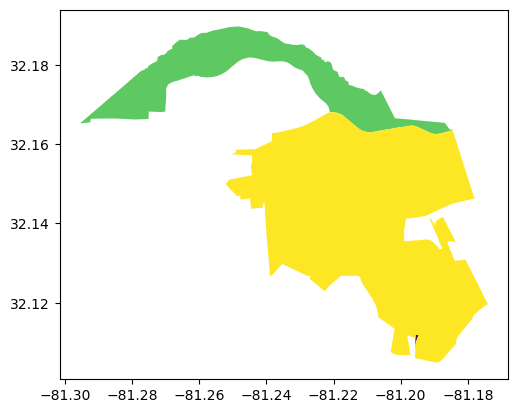

In [6]:
# The tiny chunk at the bottom should be with the precinct above it, verified by maps
ga_prec_shape[(ga_prec_shape["UNIQUE_ID"].isin(["051-7-11C SAVANNAH FIRE STATION 14"]) | (ga_prec_shape["PRECINCT_I"].str.contains("8-18C")))].plot(column = "ID")

In [7]:
# Clean up the duplicate, assign the piece of this precinct to the correct location
ga_prec_shape.loc[(ga_prec_shape["UNIQUE_ID"]=="051-7-11C SAVANNAH FIRE STATION 14")&(ga_prec_shape["DATA"]==305),"UNIQUE_ID"] = "051-8-18C SAVANNAH FIRST 7TH DAY ADV CHURCH"

# Sort file to preserve correct data after dissolve
ga_prec_shape.sort_values("PRECINCT_N", inplace = True, ascending = False)

# Dissolve the file and clean the indices
ga_prec_shape = ga_prec_shape.dissolve("UNIQUE_ID")
ga_prec_shape.reset_index(inplace = True, drop = False)

<AxesSubplot: >

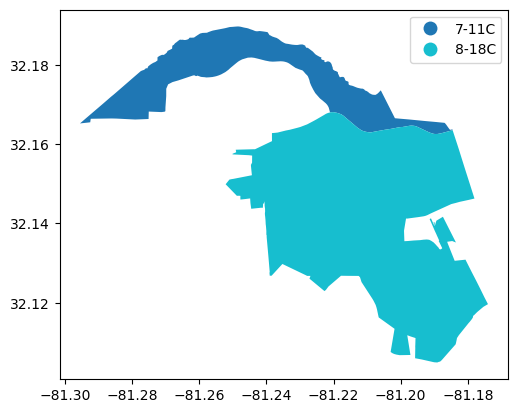

In [8]:
# Look at results
ga_prec_shape[(ga_prec_shape["UNIQUE_ID"].isin(["051-7-11C SAVANNAH FIRE STATION 14"]) | (ga_prec_shape["PRECINCT_I"].str.contains("8-18C")))].plot(column = "PRECINCT_I", legend = True)

## Join Files Together

In [9]:
joined_pber = pd.merge(ga, ga_prec_shape, how = "outer", on = "UNIQUE_ID", indicator = True)

print(joined_pber["_merge"].value_counts(dropna = False))

# joined_pber[joined_pber["_merge"]=="left_only"].to_csv("./election_results.csv", index = False)
# joined_pber[joined_pber["_merge"]=="right_only"].to_csv("./precincts.csv", index = False)

both          2710
left_only       12
right_only      10
Name: _merge, dtype: int64


## Sort out Unjoined Precincts

In [10]:
# Look into precincts with election results that didn't join
print(list(joined_pber[joined_pber["_merge"]=="left_only"]["UNIQUE_ID"]))

# Look into precincts with only shape components that didn't join
print(list(joined_pber[joined_pber["_merge"]=="right_only"]["UNIQUE_ID"]))

# Note: The precincts with only shape components do not appear to have any votes, and seem to be added to fill out the map of the state. Vote values for these precincts will be filled to zero

['051-2-06C ELI WHITNEY COMPLEX - SAVANNAH', '051-3-14C OGLETHORPE CHARTER ACADEMY - SAVANNAH', '051-5-06C SEED CHURCH - SAVANNAH', '051-6-02C WINDSOR FOREST BAPTIST - SAVANNAH', '051-6-10C GEORGETOWN ELEMENTARY - SAVANNAH', '051-6-11C COASTAL GA BOTANICAL GARDENS - SAVANNAH', '051-7-08C BLOOMINGDALE COMM CTR - SAVANNAH', '051-7-09C COMPASSION CHRISTIAN, HENDERSON - SAVANNAH', '051-7-13C SOUTHSIDE FIRE TRNG CTR - GARDEN CITY', '051-8-03C SILK HOPE BAPTIST CHURCH - GARDEN CITY', '121-SS07D', '137-CITY OF BALDWIN']
['029-029FTSTEW', '051-051XFTPU', '053-053FTBEN1', '053-053FTBEN2', '053-053FTBEN3', '215-215FTBEN1', '215-215FTBEN2', '215-215FTBEN3', '215-215FTBEN4', '215-215ZZZZZZ']


Precincts with only election results fall into 1 of 3 categories:
1. (10 of 12) In Savannah and need to be split by a municipal boundary line
2. (1 of 12) Lone precinct in Fulton that needs to be added
3. (1 of 12) Lone precinct in Habersham County where City of Baldwin needs to be added

# Savannah Precincts

https://data-sagis.opendata.arcgis.com/datasets/SAGIS::municipality/explore?location=31.783763%2C-80.756713%2C8.60

In [11]:
# Load in a municipal boundaries file
municipal_boundaries = gp.read_file("./raw-from-source/Municipality/Municipality.shp")
municipal_boundaries = municipal_boundaries.to_crs(ga_prec_shape.crs)

In [12]:
# Get the IDs for the precincts we already have in the shapefile
already_have = ga_prec_shape[ga_prec_shape["UNIQUE_ID"].isin(['051-2-06C ELI WHITNEY COMPLEX',
 '051-3-14C OGLETHORPE CHARTER ACADEMY',
 '051-5-06C SEED CHURCH',
 '051-6-02C WINDSOR FOREST BAPTIST',
 '051-6-10C GEORGETOWN ELEMENTARY',
 '051-6-11C COASTAL GA BOTANICAL GARDENS',
 '051-7-08C BLOOMINGDALE COMM CTR',
 '051-7-09C COMPASSION CHRISTIAN, HENDERSON',
 '051-7-13C SOUTHSIDE FIRE TRNG CTR',
 '051-8-03C SILK HOPE BAPTIST CHURCH'])]

# Get the names of the IDs we'll need to create, this is basically the portion of the precinct in that municipality
ga_splits = ['051-2-06C ELI WHITNEY COMPLEX - SAVANNAH',
 '051-3-14C OGLETHORPE CHARTER ACADEMY - SAVANNAH',
 '051-5-06C SEED CHURCH - SAVANNAH',
 '051-6-02C WINDSOR FOREST BAPTIST - SAVANNAH',
 '051-6-10C GEORGETOWN ELEMENTARY - SAVANNAH',
 '051-6-11C COASTAL GA BOTANICAL GARDENS - SAVANNAH',
 '051-7-08C BLOOMINGDALE COMM CTR - SAVANNAH',
 '051-7-09C COMPASSION CHRISTIAN, HENDERSON - SAVANNAH',
 '051-7-13C SOUTHSIDE FIRE TRNG CTR - GARDEN CITY',
 '051-8-03C SILK HOPE BAPTIST CHURCH - GARDEN CITY']

where_to_split = {val.split(" - ")[0]:val.split(" - ")[1] for val in ga_splits}

                         UNIQUE_ID  \
248  051-2-06C ELI WHITNEY COMPLEX   

                                              geometry    ID      AREA  DATA  \
248  POLYGON ((-81.02948 32.06200, -81.03000 32.060...  5897  4.897956   265   

     DISTRICT  CTYSOSID   FIPS FIPS2  CTYNAME CNTY   COUNTY PRECINCT_I  \
248  0512-06C  0512-06C  13051   051  Chatham   25  CHATHAM      2-06C   

                    PRECINCT_N  
248  2-06C ELI WHITNEY COMPLEX  
   OBJECTID_1  OBJECTID  OBJECTID_2  MUNICIPALI  MUNICIPA_1       ACRES  SYM  \
3       13911        22           9          10           2  72803.6083    2   

       NAME  SQ_MILES  CHATCOBND_  CHATCOBN_1  DISTANCE  \
3  SAVANNAH  113.5328           2           0         0   

                                 GlobalID CITYID    SHAPESTAre    SHAPESTLen  \
3  {D87F3624-C2F3-48DF-A482-B2BD769B8949}    SAV  3.186952e+09  1.262336e+06   

                                            geometry  
3  MULTIPOLYGON (((-81.24265 31.96726, -81.24259 ..

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/

(2722, 14)
051-3-14C OGLETHORPE CHARTER ACADEMY - SAVANNAH
                 UNIQUE_ID                                           geometry  \
276  051-5-06C SEED CHURCH  POLYGON ((-81.13426 32.03539, -81.13411 32.035...   

       ID      AREA  DATA  DISTRICT  CTYSOSID   FIPS FIPS2  CTYNAME CNTY  \
276  9730  9.984475   282  0515-06C  0515-06C  13051   051  Chatham   25   

      COUNTY PRECINCT_I         PRECINCT_N  
276  CHATHAM      5-06C  5-06C SEED CHURCH  
   OBJECTID_1  OBJECTID  OBJECTID_2  MUNICIPALI  MUNICIPA_1       ACRES  SYM  \
3       13911        22           9          10           2  72803.6083    2   

       NAME  SQ_MILES  CHATCOBND_  CHATCOBN_1  DISTANCE  \
3  SAVANNAH  113.5328           2           0         0   

                                 GlobalID CITYID    SHAPESTAre    SHAPESTLen  \
3  {D87F3624-C2F3-48DF-A482-B2BD769B8949}    SAV  3.186952e+09  1.262336e+06   

                                            geometry  
3  MULTIPOLYGON (((-81.24265 31.96726, 

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

(2724, 14)
051-6-02C WINDSOR FOREST BAPTIST - SAVANNAH
                           UNIQUE_ID  \
286  051-6-10C GEORGETOWN ELEMENTARY   

                                              geometry    ID        AREA  \
286  POLYGON ((-81.15473 31.71307, -81.15474 31.713...  9498  147.547256   

     DATA  DISTRICT  CTYSOSID   FIPS FIPS2  CTYNAME CNTY   COUNTY PRECINCT_I  \
286   294  0516-10C  0516-10C  13051   051  Chatham   25  CHATHAM      6-10C   

                      PRECINCT_N  
286  6-10C GEORGETOWN ELEMENTARY  
   OBJECTID_1  OBJECTID  OBJECTID_2  MUNICIPALI  MUNICIPA_1       ACRES  SYM  \
3       13911        22           9          10           2  72803.6083    2   

       NAME  SQ_MILES  CHATCOBND_  CHATCOBN_1  DISTANCE  \
3  SAVANNAH  113.5328           2           0         0   

                                 GlobalID CITYID    SHAPESTAre    SHAPESTLen  \
3  {D87F3624-C2F3-48DF-A482-B2BD769B8949}    SAV  3.186952e+09  1.262336e+06   

                                       

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

(2726, 14)
051-6-11C COASTAL GA BOTANICAL GARDENS - SAVANNAH
                           UNIQUE_ID  \
292  051-7-08C BLOOMINGDALE COMM CTR   

                                              geometry    ID       AREA  DATA  \
292  POLYGON ((-81.38473 32.07952, -81.38475 32.079...  9477  37.749474   302   

     DISTRICT  CTYSOSID   FIPS FIPS2  CTYNAME CNTY   COUNTY PRECINCT_I  \
292  0517-08C  0517-08C  13051   051  Chatham   25  CHATHAM      7-08C   

                      PRECINCT_N  
292  7-08C BLOOMINGDALE COMM CTR  
   OBJECTID_1  OBJECTID  OBJECTID_2  MUNICIPALI  MUNICIPA_1       ACRES  SYM  \
3       13911        22           9          10           2  72803.6083    2   

       NAME  SQ_MILES  CHATCOBND_  CHATCOBN_1  DISTANCE  \
3  SAVANNAH  113.5328           2           0         0   

                                 GlobalID CITYID    SHAPESTAre    SHAPESTLen  \
3  {D87F3624-C2F3-48DF-A482-B2BD769B8949}    SAV  3.186952e+09  1.262336e+06   

                                   

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

(2728, 14)
051-7-09C COMPASSION CHRISTIAN, HENDERSON - SAVANNAH
                             UNIQUE_ID  \
295  051-7-13C SOUTHSIDE FIRE TRNG CTR   

                                              geometry    ID      AREA  DATA  \
295  POLYGON ((-81.23897 32.07367, -81.23035 32.072...  9512  3.634829   307   

     DISTRICT  CTYSOSID   FIPS FIPS2  CTYNAME CNTY   COUNTY PRECINCT_I  \
295  0517-13C  0517-13C  13051   051  Chatham   25  CHATHAM      7-13C   

                        PRECINCT_N  
295  7-13C SOUTHSIDE FIRE TRNG CTR  
   OBJECTID_1  OBJECTID  OBJECTID_2  MUNICIPALI  MUNICIPA_1      ACRES  SYM  \
0       13908        21          10          11           6  9238.0126    6   

          NAME  SQ_MILES  CHATCOBND_  CHATCOBN_1  DISTANCE  \
0  GARDEN CITY   14.4344           2           0         0   

                                 GlobalID CITYID    SHAPESTAre   SHAPESTLen  \
0  {E5A52CC4-3718-418F-B52E-7958F8820389}     GC  4.024062e+08  154234.6865   

                        

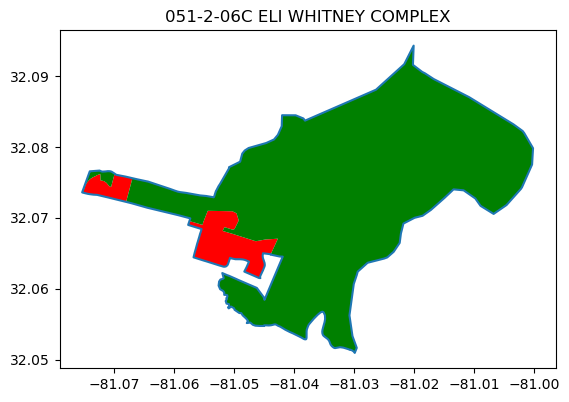

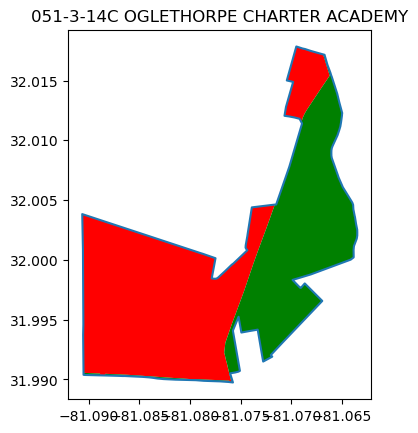

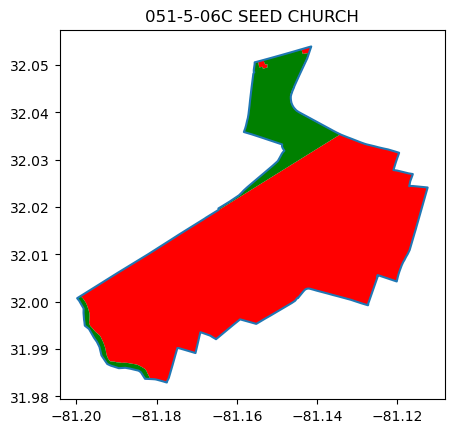

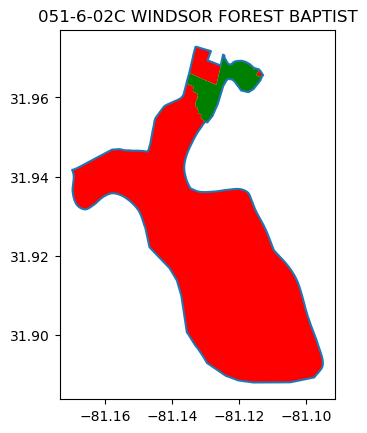

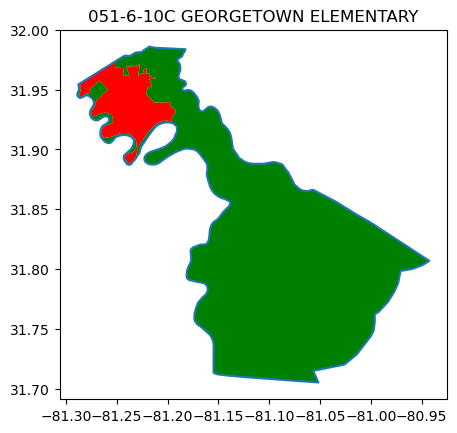

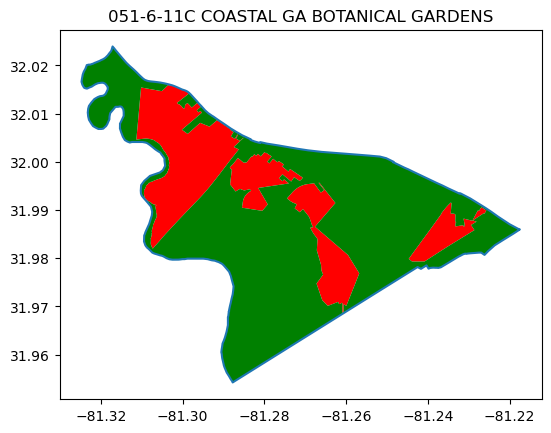

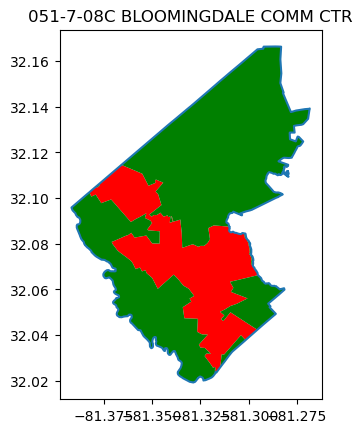

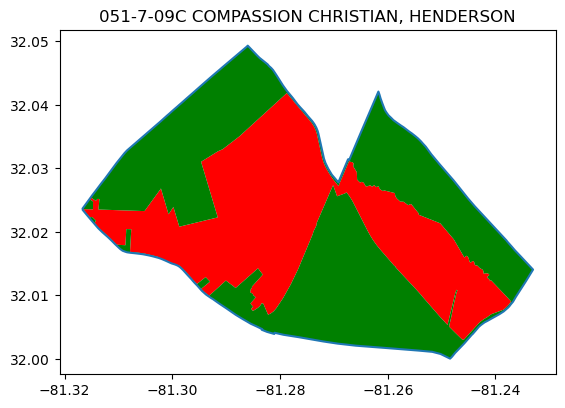

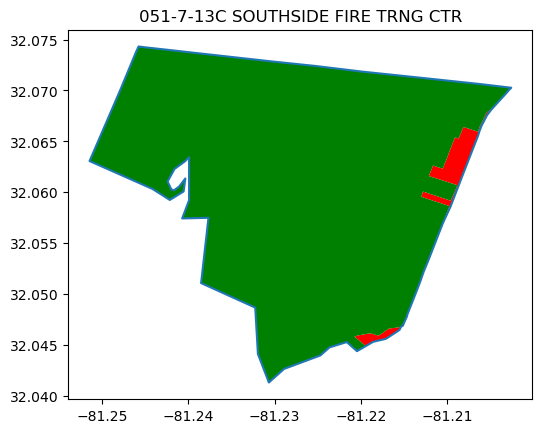

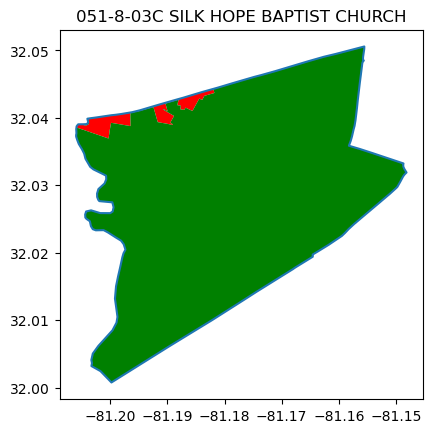

In [13]:
for key, val in where_to_split.items():
    print(ga_prec_shape[ga_prec_shape["UNIQUE_ID"]==key])
    print(municipal_boundaries[municipal_boundaries["NAME"]==val])

    intersected_prec_to_add = gp.overlay(ga_prec_shape[ga_prec_shape["UNIQUE_ID"]==key], municipal_boundaries[municipal_boundaries["NAME"]==val], keep_geom_type = True, how = "intersection")
    existing_prec_w_hole = gp.overlay(ga_prec_shape[ga_prec_shape["UNIQUE_ID"]==key], municipal_boundaries[municipal_boundaries["NAME"]==val], keep_geom_type = True, how = "difference")
    ax = ga_prec_shape[ga_prec_shape["UNIQUE_ID"]==key].boundary.plot()
    ax.set_title(key)
    intersected_prec_to_add.plot(ax = ax, color = "red")
    existing_prec_w_hole.plot(ax = ax, color = "green")
    #print(ga_prec_shape.shape)
    ga_prec_shape = ga_prec_shape[ga_prec_shape["UNIQUE_ID"]!=key]
    intersected_prec_to_add = intersected_prec_to_add[list(ga_prec_shape.columns)]
    intersected_prec_to_add["UNIQUE_ID"] = key + " - " + val
    existing_prec_w_hole = existing_prec_w_hole[list(ga_prec_shape.columns)]
    ga_prec_shape = gp.GeoDataFrame(pd.concat([ga_prec_shape, intersected_prec_to_add, existing_prec_w_hole]))
    ga_prec_shape.reset_index(inplace = True, drop = True)
    print(ga_prec_shape.shape)

    print(key + " - " + val)
#     print(test)
#     print(test_2)

# Fulton Precincts

Note: Can look at the map here: https://www.fultoncountyga.gov/-/media/Departments/IT_GIS/Printable-Maps/2022-Maps/VotingPrecinctsNorth_ep_v2.ashx

https://gismaps.fultoncountyga.gov/portalpub/apps/webappviewer/index.html?id=2a4d58ffc37f468794644f2269472157

<AxesSubplot: >

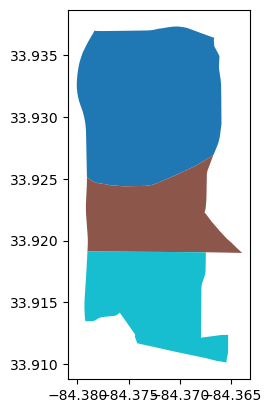

In [14]:
# Plot the precincts from which we'll be adding a new one
ga_prec_shape[(ga_prec_shape["CTYNAME"]=="Fulton")&(ga_prec_shape["PRECINCT_I"].str.contains("SS07"))].plot(column = "PRECINCT_I")

<AxesSubplot: >

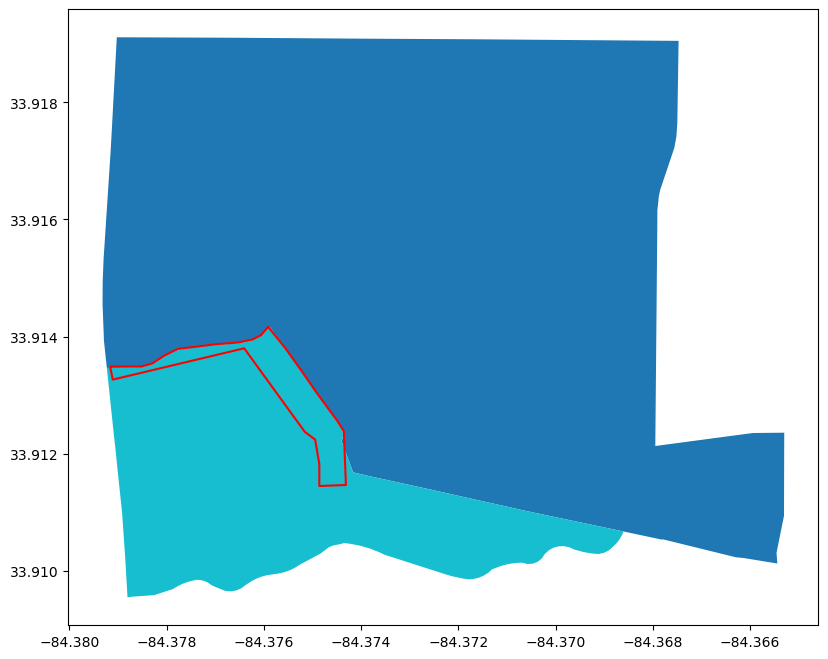

In [15]:
# Load in the file we'll need (drawn in Google Maps)
gp.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

fp="./raw-from-source/Fulton_Precinct/ss07d.kml" 

gdf_list = []
for layer in fiona.listlayers(fp):    
    gdf = gp.read_file(fp, driver='LIBKML', layer=layer)
    gdf_list.append(gdf)

gdf = gp.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
gdf = gdf.to_crs(ga_prec_shape.crs)

# Look at the outline of the precinct we'll be adding
ax = ga_prec_shape[(ga_prec_shape["CTYNAME"]=="Fulton")&(ga_prec_shape["PRECINCT_I"].str.contains("SS07C")) | (ga_prec_shape["PRECINCT_I"].str.contains("SS11C"))].plot(column = "PRECINCT_I", figsize = (12,8))
gdf.boundary.plot(ax = ax, color = "red")

In [16]:
# Remove the geometries we want to add
temp = gp.overlay(ga_prec_shape[(ga_prec_shape["CTYNAME"]=="Fulton")&(ga_prec_shape["PRECINCT_I"].str.contains("SS07C")) | (ga_prec_shape["PRECINCT_I"].str.contains("SS11C"))],gdf,how = "difference")

# Combine them back together
fulton_ss07c = temp.iloc[[1]].copy(deep = True)
added_pieces = temp.iloc[[0]].explode().copy(deep = True)
added_pieces.reset_index(inplace = True, drop = True)
combined = gp.GeoDataFrame(pd.concat([added_pieces, fulton_ss07c]))

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


<AxesSubplot: >

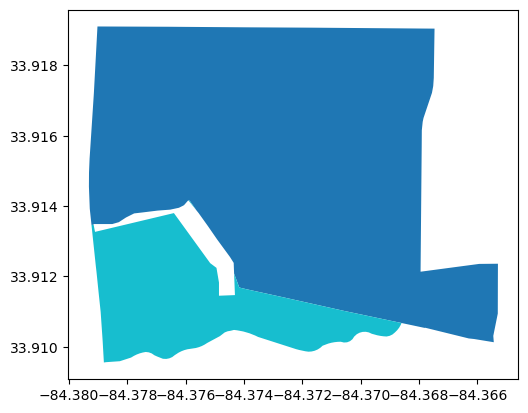

In [17]:
dissolved = combined.dissolve("UNIQUE_ID")
dissolved.reset_index(inplace = True, drop = False)
dissolved.plot(column = "UNIQUE_ID")

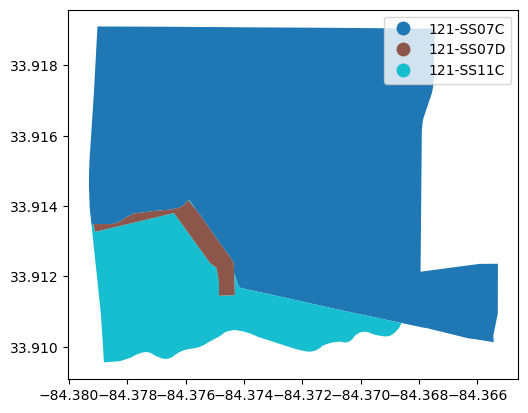

In [18]:
dissolved = dissolved[list(ga_prec_shape.columns)]

for col in list(ga_prec_shape.columns):
    if col != "geometry":
        gdf[col] = fulton_ss07c[col].values[0]
        
gdf = gdf[list(ga_prec_shape.columns)]

gdf["DISTRICT"] = "121SS07D"
gdf["CTYSOSID"] = "121SS07D"
gdf["PRECINCT_I"] = "SS07D"
gdf["PRECINCT_N"] = "SS07D"
gdf["UNIQUE_ID"] = "121-SS07D"

adding_back = gp.GeoDataFrame(pd.concat([dissolved, gdf]))

adding_back.plot(column = "UNIQUE_ID", legend = True)

ga_prec_shape = ga_prec_shape[~((ga_prec_shape["CTYNAME"]=="Fulton")&(ga_prec_shape["PRECINCT_I"].str.contains("SS07C")) | (ga_prec_shape["PRECINCT_I"].str.contains("SS11C")))]

ga_prec_shape = gp.GeoDataFrame(pd.concat([ga_prec_shape, adding_back]))

# Habersham Precincts

- https://nowhabersham.com/baldwin-combining-with-habersham-south-voting-precinct/
- https://nowhabersham.com/habersham-to-open-all-6-precincts-election-day/

In [19]:
PLACE_PATH = "/Users/peterhorton/Documents/RDH/raw_data/census/2020_PLACE_shp/ga_2020_place/ga_2020_place.shp"
PLACE_CSV_PATH = "/Users/peterhorton/Documents/RDH/raw_data/census/2020_PL_csv/ga_pl2020_place/ga_pl2020_place.csv"

In [20]:
# Load in a place shapefile and a place csv
ga_places = gp.read_file(PLACE_PATH)
ga_places_csv = pd.read_csv(PLACE_CSV_PATH)

<AxesSubplot: >

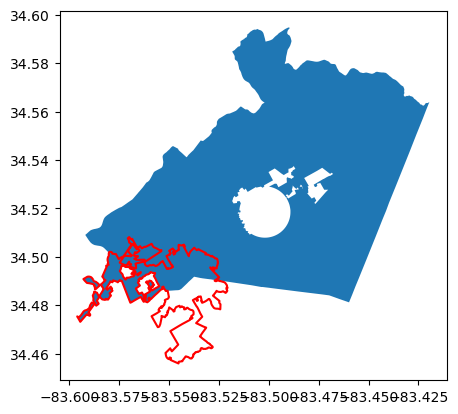

In [21]:
# Plot Habersham South Precinct Against the City of Baldwin
ax = ga_prec_shape[(ga_prec_shape["FIPS2"]=="137")&(ga_prec_shape["PRECINCT_N"]=="HABERSHAM SOUTH")].plot()
ga_places[ga_places["PLACENS"]==2403149].boundary.plot(ax = ax, color = "red")

In [22]:
# Intersect the file
hab_inter = gp.overlay(ga_prec_shape[(ga_prec_shape["FIPS2"]=="137")&(ga_prec_shape["PRECINCT_N"]=="HABERSHAM SOUTH")], ga_places[ga_places["PLACENS"]==2403149], how = "intersection")

# Generate a spatial difference
hab_diff = gp.overlay(ga_prec_shape[(ga_prec_shape["FIPS2"]=="137")&(ga_prec_shape["PRECINCT_N"]=="HABERSHAM SOUTH")], ga_places[ga_places["PLACENS"]==2403149], how = "difference")

# Remove Habersham South
ga_prec_shape = ga_prec_shape[ga_prec_shape["PRECINCT_N"]!="HABERSHAM SOUTH"]

hab_inter["PRECINCT_N"] = "CITY OF BALDWIN"
hab_inter["UNIQUE_ID"] = "137-CITY OF BALDWIN"

hab_inter = hab_inter[list(ga_prec_shape.columns)]
hab_diff = hab_diff[list(ga_prec_shape.columns)]

ga_prec_shape = gp.GeoDataFrame(pd.concat([ga_prec_shape, hab_inter, hab_diff]))
ga_prec_shape.reset_index(inplace = True, drop = True)

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [23]:
ga_prec_shape = ga_prec_shape[["UNIQUE_ID","geometry"]]

## Additional Cleaning

From an earlier iteration of this file, we discovered that Lamar County's boundaries appear to be incorrect

### Lamar County

In [24]:
lamar_correct = gp.read_file("./raw-from-source/Lamar/lamar_corrected_precincts/lamar_corrected_precincts.shp")

renaming = {'District 1 - Barnesville-Lamar County Library':"171-BARNESVILLE",
'District 2A - Chappell Mill Volunteer Fire Department':"171-CHAPPELL MILL V. FD",
'District 2B - Senior Center Building':"171-SENIOR CITZEN BLDG",
'District 2C - Redbone Community House':"171-REDBONE",
'District 3 - Lamar County Service Center':'171-L C S C',
'District 4 - Milner Community Library':'171-MILNER'}

lamar_correct["PRECINCT"] = lamar_correct["PRECINCT"].map(renaming)

lamar_correct.rename(columns = {"PRECINCT":"UNIQUE_ID"}, inplace = True)

ga_non_lamar = ga_prec_shape[~(ga_prec_shape["UNIQUE_ID"].str[0:3]=="171")]

ga_prec_shape = gp.GeoDataFrame(pd.concat([ga_non_lamar, lamar_correct]))
ga_prec_shape.reset_index(inplace = True, drop = True)

## Attempt the File Join Again

In [25]:
print(ga_prec_shape.head())

  UNIQUE_ID                                           geometry
0    001-1B  POLYGON ((-82.31535 31.94637, -82.31508 31.946...
1    001-1C  POLYGON ((-82.28530 31.85049, -82.28498 31.850...
2     001-2  POLYGON ((-82.28213 31.84844, -82.28193 31.848...
3   001-3A1  POLYGON ((-82.26720 31.85501, -82.26715 31.855...
4    001-3C  POLYGON ((-82.19946 31.81098, -82.19264 31.811...


In [26]:
ga_prec_shape = gp.read_file("./raw-from-source/ga_precs_w_changes.shp")

In [27]:
ga_prec_shape = ga_prec_shape[["UNIQUE_ID", "geometry"]]

## Swap in Liberty County

In [28]:
ga_prec_shape[ga_prec_shape["UNIQUE_ID"].str[0:3]=="179"]

,UNIQUE_ID,geometry
2041,179-GUM BRANCH,"POLYGON ((-81.69576 31.81411, -81.69584 31.814..."
2042,179-LYMAN HALL,"POLYGON ((-81.61457 31.79475, -81.61465 31.794..."
2043,179-RICEBORO,"POLYGON ((-81.44763 31.65612, -81.44808 31.656..."
2723,179-FLEMING EAST,"POLYGON ((-81.39458 31.81817, -81.39615 31.814..."
2724,179-HINESVILLE,"MULTIPOLYGON (((-81.57341 31.83139, -81.57335 ..."
2725,179-PROGRESSIVE CHURCH,"POLYGON ((-81.62788 31.82396, -81.62814 31.823..."
2726,179-MEMORIAL DR,"POLYGON ((-81.60336 31.83024, -81.60305 31.830..."
2727,179-LEWIS FRASIER,"POLYGON ((-81.60409 31.80692, -81.60418 31.806..."
2728,179-PERFORMING ARTS CTR,"POLYGON ((-81.57334 31.84803, -81.57406 31.849..."
2729,179-LIBERTY COUNTY COMPLEX,"MULTIPOLYGON (((-81.36716 31.83127, -81.36660 ..."


In [29]:

liberty = gp.read_file("./raw-from-source/Liberty/liberty.geojson")

In [30]:
liberty = liberty.to_crs(ga_prec_shape.crs)

In [31]:
liberty["UNIQUE_ID"] = "179" + "-" + liberty["Name"].astype(str).str.upper()

In [32]:
liberty.drop(["Name"], axis = 1)
liberty = liberty[["UNIQUE_ID", "geometry"]]

In [33]:
set(liberty["UNIQUE_ID"]) - set(ga_prec_shape[ga_prec_shape["UNIQUE_ID"].str[0:3]=="179"]["UNIQUE_ID"])

{'179-ALLENHURST',
 '179-BUTTON GWINNETT',
 '179-GUMBRANCH',
 '179-HINESVILLE LODGE #271',
 '179-MEMORIAL DRIVE EAST',
 '179-WALTHOURVILLE'}

In [34]:
set(ga_prec_shape[ga_prec_shape["UNIQUE_ID"].str[0:3]=="179"]["UNIQUE_ID"]) - set(liberty["UNIQUE_ID"])

{'179-GUM BRANCH',
 '179-MEMORIAL DR',
 '179-PERFORMING ARTS CTR',
 '179-PROGRESSIVE CHURCH',
 '179-TOWN OF ALLENHURST',
 '179-VICTORY BAPTIST'}

In [35]:
name_update_dict = {'179-ALLENHURST':'179-TOWN OF ALLENHURST',
 '179-BUTTON GWINNETT':'179-PERFORMING ARTS CTR',
 '179-GUMBRANCH':'179-GUM BRANCH',
 '179-HINESVILLE LODGE #271':'179-PROGRESSIVE CHURCH',
 '179-MEMORIAL DRIVE EAST':'179-MEMORIAL DR',
 '179-WALTHOURVILLE':'179-VICTORY BAPTIST'}

In [36]:
liberty["UNIQUE_ID"] = liberty["UNIQUE_ID"].map(name_update_dict).fillna(liberty["UNIQUE_ID"])

In [37]:
ga_prec_shape = ga_prec_shape[ga_prec_shape["UNIQUE_ID"].str[0:3]!="179"]
ga_prec_shape = pd.concat([liberty, ga_prec_shape])

In [38]:
joined_pber = gp.GeoDataFrame(pd.merge(ga, ga_prec_shape, how = "outer", on = "UNIQUE_ID", indicator = True))
print(joined_pber["_merge"].value_counts(dropna = False))

joined_pber.drop("_merge", inplace = True, axis = 1)

both          2722
right_only      10
left_only        0
Name: _merge, dtype: int64


In [39]:
ga_county_dict = dict(zip(ga["COUNTYFP"].astype(str).str.zfill(3), ga["county"]))

In [40]:
joined_pber.loc[joined_pber["COUNTYFP"].isna(), "COUNTYFP"] = joined_pber["UNIQUE_ID"].apply(lambda x : x.split("-")[0])
joined_pber.loc[joined_pber["county"].isna(), "county"] = joined_pber["UNIQUE_ID"].apply(lambda x : ga_county_dict[x.split("-")[0]])
joined_pber.loc[joined_pber["precinct"].isna(), "precinct"] = joined_pber["UNIQUE_ID"].apply(lambda x : x.split("-")[1])

In [41]:
joined_pber = joined_pber.fillna(0)


In [42]:
ga_elec_prec_pre_splits = joined_pber.copy(deep = True)

In [43]:
# Define a races column
races = [i for i in ga_elec_prec_pre_splits.columns if i not in ["UNIQUE_ID","geometry","COUNTYFP","county","precinct"]]

## Look If Splits Are Needed

In [44]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:5]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]
        
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in ga_elec_prec_pre_splits.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0) and ("GSL" in contest or "GCO" in contest or "GSU" in contest):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
sldl_check_list = {i:contains_sldl(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
cong_check_list = {i:contains_cong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldu_check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [45]:
split_precincts_list

{'001-1C': {'SL': ['157', '178']},
 '001-3C': {'SL': ['157', '178']},
 '001-5B': {'SL': ['157', '178']},
 '013-01': {'SL': ['104', '119'], 'SU': ['46', '47']},
 '013-05': {'SL': ['119', '120']},
 '013-13': {'SU': ['45', '46']},
 '013-16': {'SL': ['104', '119']},
 '015-CARTERSVILLE WEST': {'SU': ['37', '52']},
 '015-CASSVILLE': {'SL': ['014', '015']},
 '015-WHITE': {'SL': ['014', '015']},
 '017-EAST': {'SL': ['148', '156']},
 '021-HOWARD 1': {'SU': ['18', '25']},
 '021-HOWARD 5': {'SU': ['18', '25']},
 '021-VINEVILLE 6': {'CON': ['02', '08']},
 '021-WARRIOR 2': {'SL': ['142', '145']},
 '029-BRYAN COUNTY ADMIN BLDG': {'SL': ['164', '166']},
 '029-DANIELSIDING': {'SL': ['164', '166']},
 '029-JOHN STEVENS WETLAND CTR': {'SL': ['164', '166']},
 '029-NEW BEGINNINGS': {'SL': ['164', '166']},
 '031-CHURCH': {'SL': ['158', '159']},
 '031-HAGIN': {'SL': ['159', '160']},
 '045-BONNER': {'SL': ['071', '072']},
 '051-1-08C GRACE UNITED METHODIST CHURCH': {'SL': ['163', '165']},
 '051-1-09C IMMANUEL

In [46]:
keep_names = ["UNIQUE_ID","geometry","COUNTYFP","county","precinct"]
st_columns = [i for i in ga_elec_prec_pre_splits.columns if i not in keep_names and "GCON" not in i and "GSL" not in i and 'GSU' not in i]
cong_columns = [i for i in ga_elec_prec_pre_splits.columns if i not in keep_names and "GCON" in i]
sldl_columns = [i for i in ga_elec_prec_pre_splits.columns if i not in keep_names and "GSL" in i]
sldu_columns = [i for i in ga_elec_prec_pre_splits.columns if i not in keep_names and "GSU" in i]


ga_20_st_prec = ga_elec_prec_pre_splits[keep_names + st_columns].copy(deep = True)
ga_20_cong_prec = ga_elec_prec_pre_splits[keep_names + cong_columns].copy(deep = True)
ga_20_sldl_prec = ga_elec_prec_pre_splits[keep_names + sldl_columns].copy(deep = True)
ga_20_sldu_prec = ga_elec_prec_pre_splits[keep_names + sldu_columns].copy(deep = True)

# Make the Needed Splits

In [47]:
ga_20_cong_prec["CONG_DIST"] = ga_20_cong_prec["UNIQUE_ID"].map(cong_check_list)
ga_20_sldl_prec["SLDL_DIST"] = ga_20_sldl_prec["UNIQUE_ID"].map(sldl_check_list)
ga_20_sldu_prec["SLDU_DIST"] = ga_20_sldu_prec["UNIQUE_ID"].map(sldu_check_list)

In [48]:
def return_splits(split_dict, level):
    for val in split_dict.keys():
        if level in val:
            return split_dict[level]

def create_splits_dict(level):
    level_splits_dict = {i:return_splits(split_precincts_list[i], level) for i in split_precincts_list.keys() if return_splits(split_precincts_list[i], level) != None }
    return level_splits_dict

In [49]:
# Load in CONG and SLDL shapefiles
ga_cong_districts = gp.read_file("./raw-from-source/Dist_Shapefiles/national_cong118_boundary/national_cong118_boundary.shp")
ga_sldl_districts = gp.read_file("./raw-from-source/Dist_Shapefiles/national_2022_elections_st_leg_lower_boundaries/national_2022_elections_st_leg_lower_boundaries.shp")
ga_sldu_districts = gp.read_file("./raw-from-source/Dist_Shapefiles/national_2022_elections_st_leg_upper_boundaries/national_2022_elections_st_leg_upper_boundaries.shp")

ga_cong_districts = ga_cong_districts.to_crs(ga_elec_prec_pre_splits.crs)
ga_sldl_districts = ga_sldl_districts.to_crs(ga_elec_prec_pre_splits.crs)
ga_sldu_districts = ga_sldu_districts.to_crs(ga_elec_prec_pre_splits.crs)

ga_cong_districts = ga_cong_districts[ga_cong_districts["STATE"]=="GA"]
ga_sldl_districts = ga_sldl_districts[ga_sldl_districts["STATE"]=="GA"]
ga_sldu_districts = ga_sldu_districts[ga_sldu_districts["STATE"]=="GA"]

In [50]:
cong_splits_dict = create_splits_dict('CON')
sldl_splits_dict = create_splits_dict('SL')
sldu_splits_dict = create_splits_dict('SU')

In [51]:
def district_splits_comb(level, splits_list, elections_gdf, district_gdf, unique_ID_col, district_gdf_ID, races_list, elections_gdf_dist_ID, fill_level = 2):
    '''
    Function to split precincts across districts that splits a precinct across the entire district map.
    Previous iterations of this code only split precincts by the districts in which votes were recorded.
    In some instances, that led to holes in the map, due to districts where no votes were recorded in a precinct, but where an intersection occurred.
    '''
    # Intersect the elections gdf with the district gdf
    need_splits = elections_gdf[elections_gdf[unique_ID_col].isin(splits_list)]
    others = elections_gdf[~elections_gdf[unique_ID_col].isin(splits_list)]
    
    pre_splits_copy = need_splits.copy(deep = True)
    
    test_join = gp.overlay(need_splits, district_gdf, how = "intersection")
    
    # Assign a district column, using the district shapefile
    test_join[elections_gdf_dist_ID] = test_join[district_gdf_ID]
    
    # Filter the intersection down to the precinct, district pairs we need
    clean_votes = test_join.copy(deep = True)
    
    clean_votes[unique_ID_col+"_new"] = clean_votes[unique_ID_col]
    
    # Remove the others and hold on to these to be merged later
    for index, row in clean_votes.iterrows():
        clean_votes.at[index, unique_ID_col+"_new"] = row[unique_ID_col]+"-("+level + "-" + row[district_gdf_ID].zfill(fill_level) + ")"
        for column in test_join:
            if column in races_list and row[elections_gdf_dist_ID].zfill(fill_level) not in column:
                clean_votes.at[index, column] = 0 
        
    lost_votes_df = generate_differences_df(pre_splits_copy, clean_votes, unique_ID_col, races_list, True)
    
    clean_votes.drop(unique_ID_col, axis = 1, inplace = True)
    clean_votes.rename(columns = {unique_ID_col+"_new":unique_ID_col}, inplace = True)

    clean_votes = clean_votes[list(others.columns)]
        
    elections_gdf = gp.GeoDataFrame(pd.concat([clean_votes, others]), crs = elections_gdf.crs)
    elections_gdf.reset_index(drop=True,inplace=True)

    
    return elections_gdf, lost_votes_df

In [52]:
def generate_differences_df(df_compare_against, df_compare_to, unique_ID_col, races_list, drop_empty = False):
    
    df_compare_against = df_compare_against[[unique_ID_col]+races_list]
    df_compare_to = df_compare_to[[unique_ID_col]+races_list]
 

    grouped_compare_against = df_compare_against.groupby(unique_ID_col).sum()
    grouped_compare_to = df_compare_to.groupby(unique_ID_col).sum()
    
    grouped_compare_against.reset_index(inplace = True, drop = False)
    grouped_compare_to.reset_index(inplace = True, drop = False)

    diffs = grouped_compare_against.set_index(unique_ID_col).subtract(grouped_compare_to.set_index(unique_ID_col))
    
    diffs["Tot_Votes"] = diffs[races_list].sum(axis=1)

    
    if drop_empty:
        diffs = diffs.loc[~(diffs==0).all(axis=1)]
        diffs = diffs.loc[:, (diffs != 0).any(axis=0)]

    return diffs

## Make Different Splits

In [53]:
ga_20_sldl_prec, sldl_diff = district_splits_comb("SLDL", list(sldl_splits_dict.keys()), ga_20_sldl_prec, ga_sldl_districts, "UNIQUE_ID", "DISTRICT", sldl_columns, "SLDL_DIST", fill_level = 3)
ga_20_sldu_prec, sldu_diff = district_splits_comb("SLDU", list(sldu_splits_dict.keys()), ga_20_sldu_prec, ga_sldu_districts, "UNIQUE_ID", "DISTRICT", sldu_columns, "SLDU_DIST")
ga_20_cong_prec, cong_diff = district_splits_comb("CONG", list(cong_splits_dict.keys()), ga_20_cong_prec, ga_cong_districts, "UNIQUE_ID", "DISTRICT", cong_columns, "CONG_DIST")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_68873/2620497255.py:13: UserWarning: `keep_geom_type=True` in overlay resulted in 207 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(need_splits, district_gdf, how = "intersection")
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_68873/2620497255.py:13: UserWarning: `keep_geom_type=True` in overlay resulted in 42 dropped geometries of different 

In [54]:
cong_diff.sort_values("Tot_Votes", inplace = True, ascending = False)
sldl_diff.sort_values("Tot_Votes", inplace = True, ascending = False)
sldu_diff.sort_values("Tot_Votes", inplace = True, ascending = False)

In [55]:
cong_diff.to_csv("./lost_cong_votes.csv")
sldl_diff.to_csv("./lost_sldl_votes.csv")
sldu_diff.to_csv("./lost_sldu_votes.csv")

- Chatham, looks okay: https://hub.arcgis.com/datasets/7827a516b7134fe0a68e2f03d7f67cc6/explore?location=32.086516%2C-81.162076%2C12.31
- Henry, looks okay: https://www.cityofstockbridge-ga.gov/files/documents/OR21-490OrdinanceauthorizingtherevisionofvotingprecinctsintheCOSonUMCMMCCandStockbridgeFirstUMC1309095415092221AM.pdf
- Floyd, looks okay:https://www.floydcountyga.gov/sites/default/files/fileattachments/elections_amp_voter_registration/page/2756/elections_floyd_county_voting_precincts.pdf, https://floydgop.org/wp-content/uploads/2022/03/Floyd_County_Voting_Precincts.pdf
- Lamar can't find a source but probably okay
https://www.lamarcountyga.com/wp-content/uploads/2022/03/Redistricting-Map.pdf, https://www.lamarcountyga.com/wp-content/uploads/2022/09/LamarCCSB-Draft1-2022-11x17-1.pdf
https://www.lamarcountyga.com/voting-information-for-the-november-3-2020-general-special-election/

## Clean up N/A assignments for districts


In [56]:
def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID, ):
    
    if elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()].shape[0]==0:
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()], district_gdf, how = "intersection")

    dist_clean['area'] = dist_clean.area

    na_assignment_dict = {}

    for val in dist_clean[unique_ID_col].unique():

        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment

    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    

    elections_gdf = elections_gdf.to_crs(original_crs)
    
    return elections_gdf

In [57]:
print(ga_20_cong_prec[ga_20_cong_prec["CONG_DIST"].isna()].shape[0])
print(ga_20_sldl_prec[ga_20_sldl_prec["SLDL_DIST"].isna()].shape[0])
print(ga_20_sldu_prec[ga_20_sldu_prec["SLDU_DIST"].isna()].shape[0])

ga_20_cong_prec = clean_na_dist_assignments(ga_20_cong_prec, ga_cong_districts, "UNIQUE_ID", "CONG_DIST", "DISTRICT")
ga_20_sldl_prec = clean_na_dist_assignments(ga_20_sldl_prec, ga_sldl_districts, "UNIQUE_ID", "SLDL_DIST", "DISTRICT")
ga_20_sldu_prec = clean_na_dist_assignments(ga_20_sldu_prec, ga_sldu_districts, "UNIQUE_ID", "SLDU_DIST", "DISTRICT")

print(ga_20_cong_prec[ga_20_cong_prec["CONG_DIST"].isna()].shape[0])
print(ga_20_sldl_prec[ga_20_sldl_prec["SLDL_DIST"].isna()].shape[0])
print(ga_20_sldu_prec[ga_20_sldu_prec["SLDU_DIST"].isna()].shape[0])

26
27
27


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_68873/1706362173.py:11: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()], district_gdf, how = "intersection")
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_68873/1706362173.py:11: UserWarning: `keep_geom_type=True` in overlay r

0
0
0


## Finalize and Release Unsplit Version

- ga_elec_prec_pre_splits
- ga_20_st_prec
- ga_20_cong_prec
- ga_20_sldl_prec
- ga_20_sldu_prec

In [58]:
# import os
# os.mkdir("./ga_2022_gen_prec")

# os.mkdir("./ga_2022_gen_prec/ga_2022_gen_prec_no_splits")
# os.mkdir("./ga_2022_gen_prec/ga_2022_gen_st_prec")
# os.mkdir("./ga_2022_gen_prec/ga_2022_gen_cong_prec")
# os.mkdir("./ga_2022_gen_prec/ga_2022_gen_sldl_prec")
# os.mkdir("./ga_2022_gen_prec/ga_2022_gen_sldu_prec")



In [59]:
ga_20_st_prec = ga_20_st_prec[["UNIQUE_ID","COUNTYFP","county","precinct"]+st_columns+["geometry"]]
ga_20_cong_prec = ga_20_cong_prec[["UNIQUE_ID","COUNTYFP","county","precinct","CONG_DIST"]+cong_columns+["geometry"]]
ga_20_sldl_prec = ga_20_sldl_prec[["UNIQUE_ID","COUNTYFP","county","precinct","SLDL_DIST"]+sldl_columns+["geometry"]]
ga_20_sldu_prec = ga_20_sldu_prec[["UNIQUE_ID","COUNTYFP","county","precinct","SLDU_DIST"]+sldu_columns+["geometry"]]

## Check Assignments

In [60]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

In [61]:
ga_20_sldl_prec["SLDL_DIST"] = ga_20_sldl_prec["SLDL_DIST"].astype(int).astype(str).str.zfill(3)
ga_20_sldu_prec["SLDU_DIST"] = ga_20_sldu_prec["SLDU_DIST"].astype(int).astype(str).str.zfill(2)
ga_20_cong_prec["CONG_DIST"] = ga_20_cong_prec["CONG_DIST"].astype(int).astype(str).str.zfill(2)

In [62]:
filtered_cong_results = ga_20_cong_prec[ga_20_cong_prec["CONG_DIST"]!="n/a"].dissolve("CONG_DIST")
filtered_cong_results.reset_index(inplace=True, drop=False)

filtered_sldl_results = ga_20_sldl_prec[ga_20_sldl_prec["SLDL_DIST"]!="n/a"].dissolve("SLDL_DIST")
filtered_sldl_results.reset_index(inplace=True, drop=False)

filtered_sldu_results = ga_20_sldu_prec[ga_20_sldu_prec["SLDU_DIST"]!="n/a"].dissolve("SLDU_DIST")
filtered_sldu_results.reset_index(inplace=True, drop=False)

In [63]:
ga_cong_districts.rename(columns = {"DISTRICT":"CONG_DIST"}, inplace = True)
ga_sldl_districts.rename(columns = {"DISTRICT":"SLDL_DIST"}, inplace = True)
ga_sldu_districts.rename(columns = {"DISTRICT":"SLDU_DIST"}, inplace = True)

In [64]:
ga_sldl_districts["SLDL_DIST"] = ga_sldl_districts["SLDL_DIST"].astype(int).astype(str).str.zfill(3)
ga_sldu_districts["SLDU_DIST"] = ga_sldu_districts["SLDU_DIST"].astype(int).astype(str).str.zfill(2)
ga_cong_districts["CONG_DIST"] = ga_cong_districts["CONG_DIST"].astype(int).astype(str).str.zfill(2)

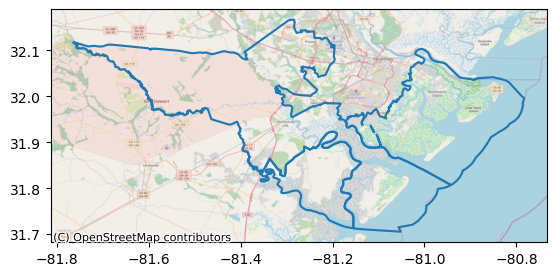

In [65]:
ax = filtered_sldl_results[filtered_sldl_results["SLDL_DIST"].isin(["164","166"])].boundary.plot()
cx.add_basemap(ax, crs = ga_sldl_districts.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)


Checking 14 precincts for differences of greater than 0.1 km^2

1) For 01 difference in area is 20.762537703649304

Scroll down to see plots of any differences

Of the 14 precincts:

3 precincts w/ a difference of 0 km^2
10 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2
Checking 180 precincts for differences of greater than 0.1 km^2

1) For 164 difference in area is 44.012316972048005
2) For 166 difference in area is 43.93322358473655
3) For 168 difference in area is 20.786805670906816

Scroll down to see plots of any differences

Of the 180 precincts:

63 precincts w/ a difference of 0 km^2
114 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2


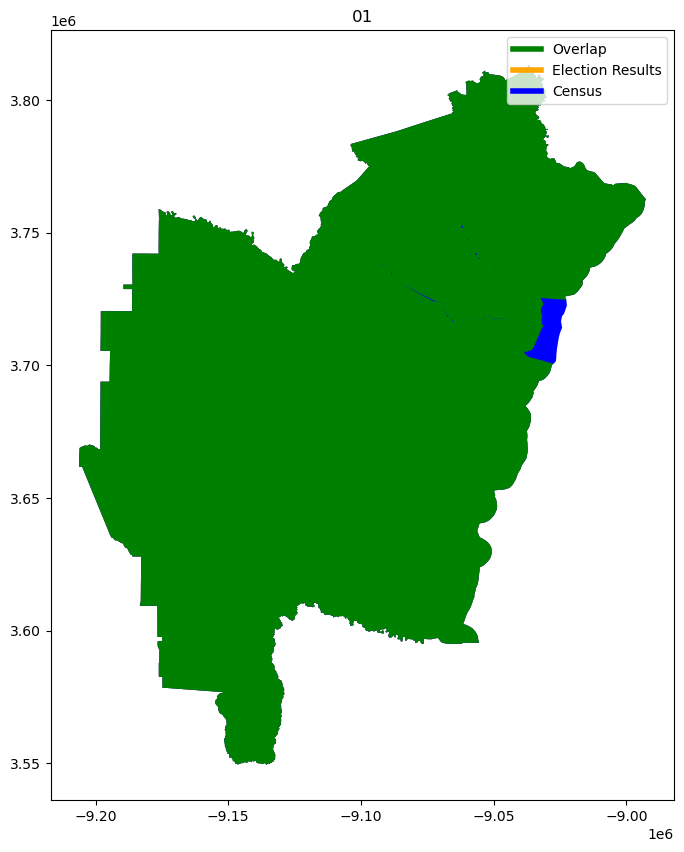

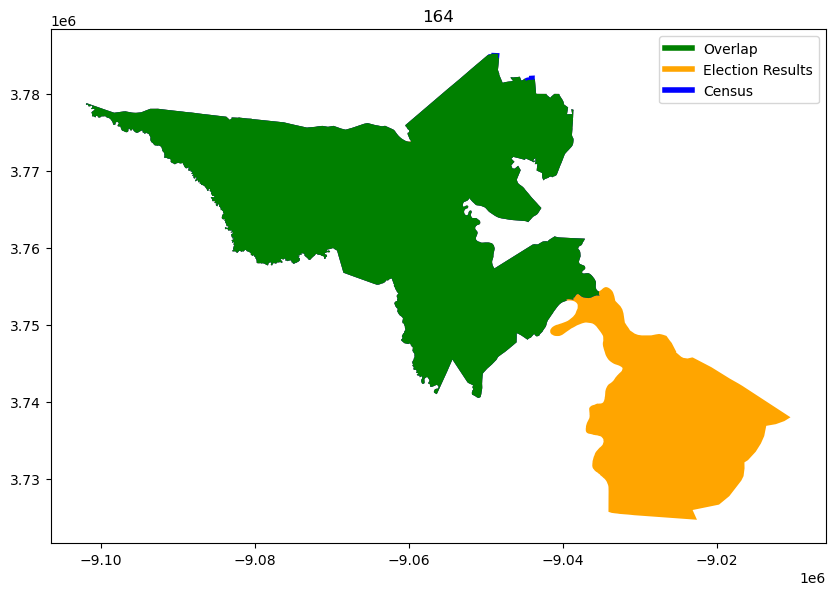

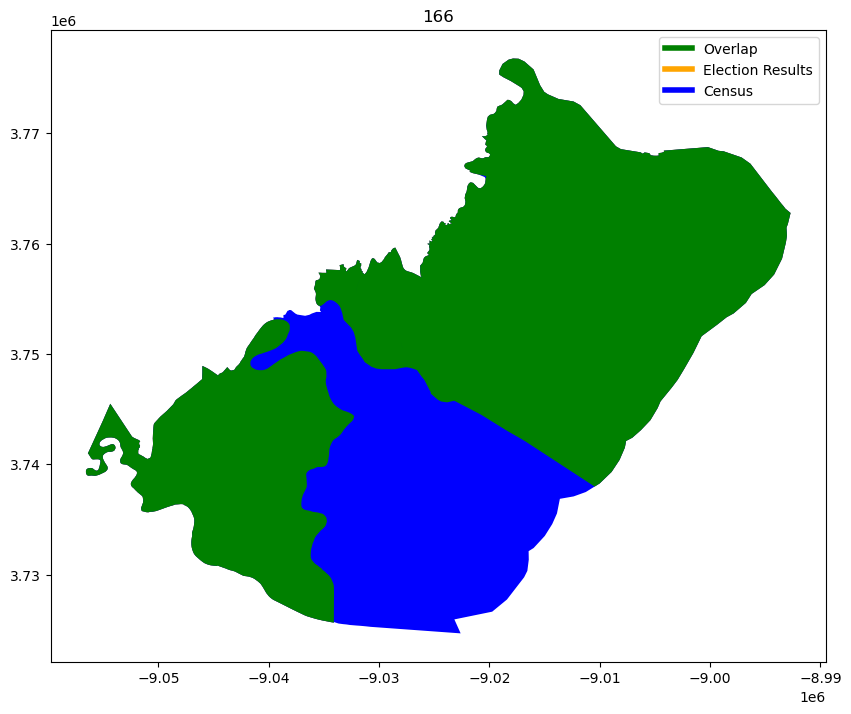

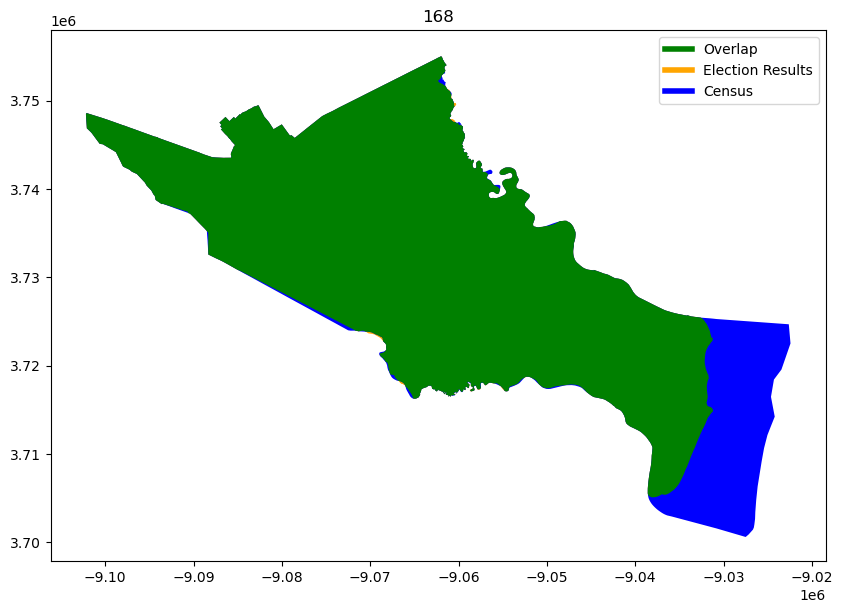

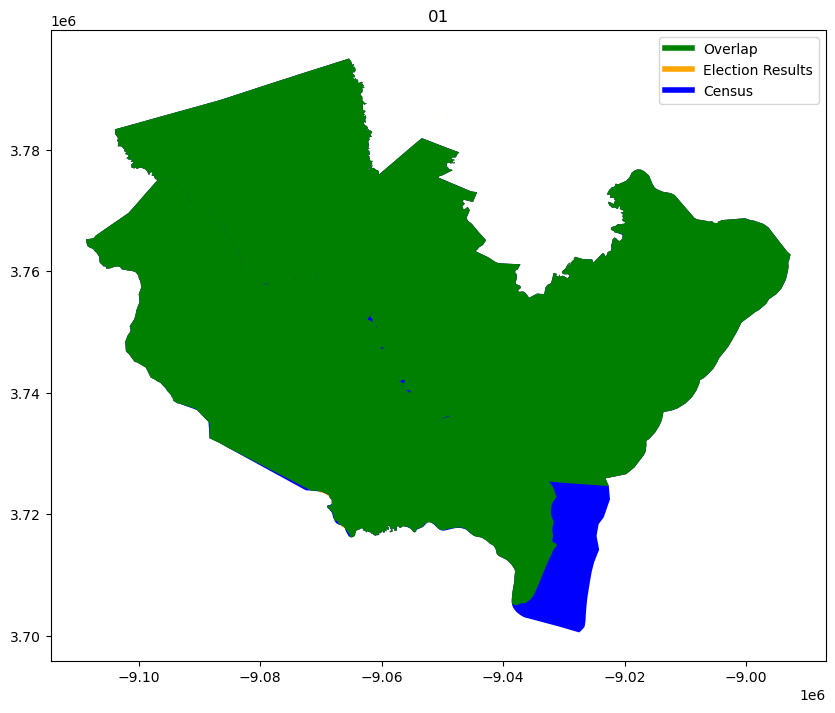

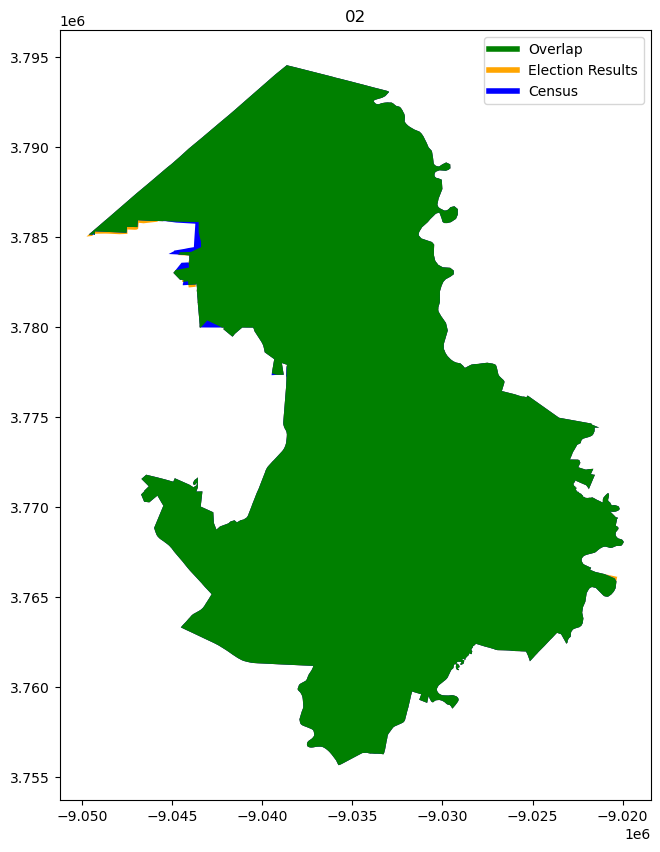

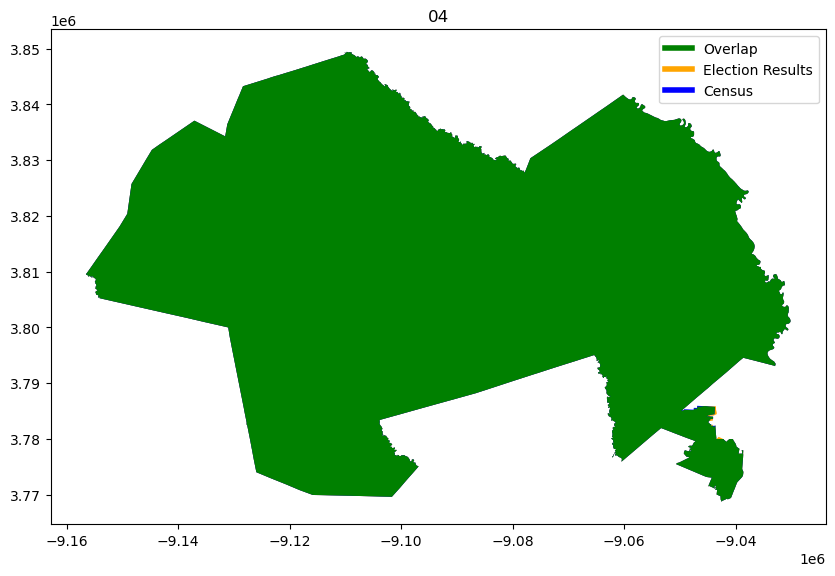

In [66]:
compare_geometries(filtered_cong_results, ga_cong_districts ,"Election Results", "Census", "CONG_DIST",area_threshold=.1)
compare_geometries(filtered_sldl_results, ga_sldl_districts ,"Election Results", "Census", "SLDL_DIST",area_threshold=.1)
compare_geometries(filtered_sldu_results, ga_sldu_districts ,"Election Results", "Census", "SLDU_DIST",area_threshold=.1)


In [67]:
for col in st_columns:
    print(col)
    ga_20_st_prec[col] = ga_20_st_prec[col].astype(int)
    
for col in sldl_columns:
    ga_20_sldl_prec[col] = ga_20_sldl_prec[col].astype(int)
    
for col in cong_columns:
    ga_20_cong_prec[col] = ga_20_cong_prec[col].astype(int)
    
for col in sldu_columns:
    ga_20_sldu_prec[col] = ga_20_sldu_prec[col].astype(int)
    
    

G22A01NO
G22A01YES
G22A02NO
G22A02YES
G22AGRDHEM
G22AGRLRAU
G22AGRRHAR
G22ATGDJOR
G22ATGLCOW
G22ATGRCAR
G22GOVDABR
G22GOVLHAZ
G22GOVRKEM
G22INSDROB
G22INSRKIN
G22LABDBOD
G22LABLAND
G22LABRTHO
G22LTGDBAI
G22LTGLGRA
G22LTGRJON
G22RFANO
G22RFAYES
G22RFBNO
G22RFBYES
G22SOSDNGU
G22SOSLMET
G22SOSRRAF
G22SUPDSEA
G22SUPRWOO
G22USSDWAR
G22USSLOLI
G22USSRWAL


In [68]:
ga_elec_prec_pre_splits.to_csv("./2022_elections.csv", index = False)

In [69]:
ga_elec_prec_pre_splits["geometry"] = ga_elec_prec_pre_splits["geometry"].buffer(0)
ga_20_st_prec["geometry"] = ga_20_st_prec["geometry"].buffer(0)
ga_20_cong_prec["geometry"] = ga_20_cong_prec["geometry"].buffer(0)
ga_20_sldl_prec["geometry"] = ga_20_sldl_prec["geometry"].buffer(0)
ga_20_sldu_prec["geometry"] = ga_20_sldu_prec["geometry"].buffer(0)

In [70]:
ga_elec_prec_pre_splits.to_file("./ga_2022_gen_prec/ga_2022_gen_prec_no_splits/ga_2022_gen_prec_no_splits.shp")
ga_20_st_prec.to_file("./ga_2022_gen_prec/ga_2022_gen_st_prec/ga_2022_gen_st_prec.shp")
ga_20_cong_prec.to_file("./ga_2022_gen_prec/ga_2022_gen_cong_prec/ga_2022_gen_cong_prec.shp")
ga_20_sldl_prec.to_file("./ga_2022_gen_prec/ga_2022_gen_sldl_prec/ga_2022_gen_sldl_prec.shp")
ga_20_sldu_prec.to_file("./ga_2022_gen_prec/ga_2022_gen_sldu_prec/ga_2022_gen_sldu_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu